# Miniproject | Learning to play Pong with Deep Reinforcement Learning

![PongUrl](https://pygame-learning-environment.readthedocs.io/en/latest/_images/pong.gif "pong")

## Introduction

### Description

Traditionally, reinforcement learning has operated on "tabular" state spaces, e.g. "State 1", "State 2", "State 3" etc. However, many important and interesting reinforcement learning problems (like moving robot arms or playing Atari games) are based on either continuous or very high-dimensional state spaces (like robot joint angles or pixels). Deep neural networks constitute one method for learning a value function or policy from continuous and high-dimensional observations. 

In this miniproject, you will teach an agent to play the game [Pong](https://pygame-learning-environment.readthedocs.io/en/latest/user/games/pong.html) from the PyGame Learning Environment. While it is possible to learn the task directly from screen pixel values as done by DQN on the Atari games, here we consider a simpler low-dimensional state space. The agent needs to control a paddle to hit a ball and drive it past it's opponent's paddle which is controlled by the computer. The state space is 7-dimensional and continuous, and consists of the following state variables:
- player paddle's y position.
- player paddle's velocity.
- cpu paddle's y position.
- ball's x position.
- ball's y position.
- ball's x velocity.
- ball's y velocity.

The agent can take one of two actions, accelerate up or accelerate down. The agent gets a reward of +1 when it scores a point, i.e, when it drives the ball past the computer-controlled paddle, and a reward of -1 when it loses a point. We define a game (or episode) to be over when either the agent (or the computer) scores 7 points, after which a new game is started. Because the episodes become very long once the agent learns to compete with its opponent, we stop training when the agent wins a certain number of games in a row (20 by default). You can change this parameter if you wish to further train and improve your agent.

We will use Policy Gradient approaches to learn the task. In supervised learning tasks, the network generates a probability distribution over the outputs, and is trained to maximize the probability of a specific target output given an observation. In Policy Gradient methods, the network generates a probability distribution over actions, and is trained to maximize expected future rewards given an observation.

You should remember that reinforcement learning is noisy! You may get different results from one trial to another, and sometimes simpler approaches will outperform more complicated ones. If you don't see any improvement, or unstable learning, double-check your model and try adjusting the learning rate.

### Prerequisites

- You should have set up the CS456 virtual conda environment and installed the dependencies as described in the document [Miniprojects | Environment Setup and XOR exercise](https://moodle.epfl.ch/pluginfile.php/2024974/mod_resource/content/6/env_setup.pdf) published on moodle. You should launch this notebook from this environment, i.e. using the CS456 python 3 kernel.
- For this miniproject you will also need to install [Pygame](https://www.pygame.org/wiki/about), Pillow, and the [PyGame Learning Environment](https://pygame-learning-environment.readthedocs.io/en/latest/user/home.html). To do so, the easiest workflow to follow is:
    - source activate ann_env
    - pip3 install Pillow
    - pip3 install pygame
    - git clone https://github.com/ntasfi/PyGame-Learning-Environment
    - cd PyGame-Learning-Environment
    - pip3 install -e .

- You should know the concepts of "policy", "policy gradient", "REINFORCE", "REINFORCE with baseline". If you want to start and haven't seen these yet in class, read Sutton & Barto (2018) Chapter 13 (13.1-13.4).

### What you will learn

- You will learn how to implement a policy gradient neural network using the REINFORCE algorithm.
- You will learn how to implement baselines with a learned value network.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night (or on an external server). If you have access to a GPU you can also use the [gpu support of tensorflow 2](https://www.tensorflow.org/install/gpu) to speed up simulations.

### Notes 
- Reinforcement learning is noisy! Normally one should average over multiple random seeds with the same parameters to really see the impact of a change to the model, but we won't do this due to time constraints. However, you should be able to see learning over time with every approach. If you don't see any improvement, or very unstable learning, double-check your model and try adjusting the learning rate.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answers to the questions. Provide clear and concise answers respecting the indicated maximum length. Keep your code tidy, organised and commented to allow us (and yourself) to understand what is going on. All plots must have axes labels as well as legends and a title where needed.

**The submitted notebook must be run by you!** We will only do random tests of your code and not re-run the full notebook. There will be fraud detection sessions at the end of the semester.

### Your names

**Before you start**: please enter your full name(s) in the field below.

In [1]:
student1 = "Yiting Zhang"
student2 = "Qi Yan"

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Setup

### Dependencies and constants

In [3]:
import os
import sys

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # No cuda available on personal laptop
os.environ["CUDA_VISIBLE_DEVICES"] = ""

os.putenv('SDL_VIDEODRIVER', 'fbcon') # settings for pygame display
os.environ["SDL_VIDEODRIVER"] = "dummy"

In [4]:
import numpy as np
import random

import warnings
warnings.filterwarnings('ignore')

import keras
import tensorflow as tf
from keras.models import Sequential, load_model, Model
from keras.layers import Dense
from keras.optimizers import Adam
from keras import backend as K

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, clear_output
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128

from ple import PLE
from ple.games.pong import Pong
import pygame

Using TensorFlow backend.


pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html
couldn't import doomish
Couldn't import doom


### Game setup

Here we load the Pong Reinforcement Learning environment from PLE. We limit each game (episode) to 7 points so that we can train faster.

We also define a preprocessing function `process_state` that normalizes the state values to have maximum norms close to 1. Feature normalization has been seen to generally help neural networks learn faster, and is common practice in deep reinforcement learning.

In [5]:
NORMALIZE_FACTORS = np.array([48, 50, 48, 64, 48, 50, 50])

def process_state(state):
    state = np.array(list(state.values()))
    state /= NORMALIZE_FACTORS
    
    return state

In [6]:
# Setting up the game environment, refer to the PLE docs if you want to know the details
game = Pong(MAX_SCORE=7)
game_env = PLE(game, fps=30, display_screen=False, state_preprocessor=process_state, reward_values = {"win": 0, "loss": 0})

### Utilities

We include a function that lets you visualize an "episode" (i.e. a series of observations resulting from the actions that the agent took in the environment).

As well, we will use the `Results` class (a wrapper around a python dictionary) to store, save, load and plot your results. You can save your results to disk with results.save('filename') and reload them with Results(filename='filename'). Use results.pop(experiment_name) to delete an old experiment.

In [7]:
def render(episode):
    
    fig = plt.figure()
    img = plt.imshow(np.transpose(episode[0],[1,0,2]))
    plt.axis('off')

    def animate(i):
        img.set_data(np.transpose(episode[i],[1,0,2]))
        return img,

    anim = FuncAnimation(fig, animate, frames=len(episode), interval=24, blit=True)
    html = HTML(anim.to_jshtml())
    
    plt.close(fig)
    !rm None0000000.png
    
    return html


class Results(dict):
    
    def __init__(self, *args, **kwargs):
        if 'filename' in kwargs:
            data = np.load(kwargs['filename'])
            super(Results, self).__init__(data)
        else:
            super(Results, self).__init__(*args, **kwargs)
        self.new_key = None
        self.plot_keys = None
        self.ylim = None
        
    def __setitem__(self, key, value):
        super().__setitem__(key, value)
        self.new_key = key

    def plot(self, window):
        clear_output(wait=True)
        for key in self:
            #Ensure latest results are plotted on top
            if self.plot_keys is not None and key not in self.plot_keys:
                continue
            elif key == self.new_key:
                continue
            self.plot_smooth(key, window)
        if self.new_key is not None:
            self.plot_smooth(self.new_key, window)
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.legend(loc='lower right')
        if self.ylim is not None:
            plt.ylim(self.ylim)
        plt.show()
        
    def plot_smooth(self, key, window):
        if len(self[key]) == 0:
            plt.plot([], [], label=key)
            return None
        y = np.convolve(self[key], np.ones((window,))/window, mode='valid')
        x = np.linspace(window/2, len(self[key]) - window/2, len(y))
        plt.plot(x, y, label=key)
        
    def save(self, filename='results'):
        np.savez(filename, **self)

### Test runs

To get an idea of how the environment works, we'll plot an episode resulting from random actions at each point in time.

In [8]:
def run_fixed_episode(env, policy):
    frames = []
    env.reset_game()
    done = False
    while not done:
        observation = env.getGameState()
        action = policy(env, observation)
        frames.append(env.getScreenRGB())
        reward = env.act(action)
        done = env.game_over()
    return frames
    
def random_policy(env, observation):
    return random.sample(env.getActionSet(), 1)[0]

In [9]:
episode = run_fixed_episode(game_env, random_policy)
render(episode)

rm: cannot remove 'None0000000.png': No such file or directory


We also define a function to run an episode with the policies that you will be training

In [10]:
def run_fixed_episode_learned(env, policy):
    frames = []
    env.reset_game()
    done = False
    while not done:
        observation = env.getGameState()
        action_idx = policy.decide(observation)
        action = env.getActionSet()[action_idx]
        frames.append(env.getScreenRGB())
        reward = env.act(action)
        done = env.game_over()
    return frames

## Experiment Loop

This is the method we will call to setup an experiment. Reinforcement learning usually operates on an Observe-Decide-Act cycle, as you can see below.

You don't need to add anything here; you will be working directly on the RL agent.

In [11]:
num_episodes = 5000

def run_experiment(experiment_name, env, num_episodes, reward_shaping=False, 
                   policy_learning_rate=0.001, value_learning_rate = 0.001, 
                   baseline=None, fileNamePolicy=None, fileNameValue=None, verbose=False, stopping_criterion=20):

    env.init()
    discount_factor = 0.99
    
    #Initiate the learning agent
    agent = RLAgent(n_obs = env.getGameStateDims()[0], policy_learning_rate = policy_learning_rate, value_learning_rate = value_learning_rate, 
                    discount=discount_factor, baseline=baseline, fileNamePolicy=fileNamePolicy, fileNameValue=fileNameValue)

    rewards = []
    all_episode_frames = []
    
    points_won = 0
    games_won = 0
    win_streak = 0
    
    for episode in range(1, num_episodes+1):
    
        #Update results plot and occasionally store an episode movie
        episode_frames = None
        if episode % 10 == 0:
            results[experiment_name] = np.array(rewards)
            results.plot(10)
            if verbose:
                print("Number of games won: " + str(int(games_won)))
                print("Number of points won: " + str(int(points_won)))
        if episode % 500 == 0:
            episode_frames = []
            
        #Reset the environment for a new episode
        env.reset_game()
            
        observation = env.getGameState()
        
        player_points = 0
        opponent_points = 0
        
        episode_steps = 0
        episode_reward = 0

        while True:
        
            if episode_frames is not None:
                episode_frames.append(env.getScreenRGB())

            # 1. Decide on an action based on the observations
            action_idx = agent.decide(observation)
            # convert action index into commands expected by the game environment
            action = game_env.getActionSet()[action_idx]

            # 2. Take action in the environment
            raw_reward = env.act(action)
            next_observation = env.getGameState()
            
            if raw_reward > 0:
                points_won += raw_reward
                player_points += raw_reward
            elif raw_reward < 0:
                opponent_points += np.abs(raw_reward)
            
            episode_steps += 1
            
            # 3. Reward shaping            
            if reward_shaping:
                auxiliary_reward = reward_design(observation)
                reward = raw_reward + auxiliary_reward
            else:
                reward = raw_reward
    
            episode_reward += reward

            # 4. Store the information returned from the environment for training
            agent.observe(observation, action_idx, reward)

            # 5. When we reach a terminal state ("done"), use the observed episode to train the network
            done = env.game_over() # Check if game is over
            if done:
                rewards.append(episode_reward)
                agent.train()
                
                # Some diagnostics
                if verbose:
                    print("Game score: " + str(int(player_points)) + "-" + str(int(opponent_points)) + " over "
                          + str(episode_steps) + " frames")
                
                # Calculating the win streak (number of consecutive games won)
                if player_points > opponent_points:
                    print("Won a game at episode " + str(episode) + "!")
                    games_won += 1
                    win_streak += 1
                else:
                    win_streak = 0
                    
                if episode_frames is not None:
                    all_episode_frames.append(episode_frames)                    
                
                break

            # Reset for next step
            observation = next_observation
        
        # Stop if you won enough consecutive games
        if win_streak == stopping_criterion:
            break
            
    return all_episode_frames, agent

One could also think to introduce a "shaping" reward to encourage the agent to return the ball in the start of training. This could be done in many ways. Here is one function that achieves this by giving the agent a tiny reward for every frame that the ball is moving towards it's opponent's side.

In [12]:
def reward_design(observation):    
    ball_vel = observation[5]
    
    auxiliary_reward = 0
    if ball_vel>0:
        auxiliary_reward = 1e-3
    return auxiliary_reward

## The Agent

Here we give the outline of a python class that will represent the reinforcement learning agent (along with its decision-making network). 

**Throughout the course of the miniproject you will be modifying this class to add additional methods and functionality.**

In [13]:
class RLAgent(object):
    
    def __init__(self, n_obs, policy_learning_rate, value_learning_rate, 
                 discount, baseline=None, fileNamePolicy=None, fileNameValue=None):

        #We need the state and action dimensions to build the network
        self.n_obs = n_obs  
        self.n_act = 1
        
        self.gamma = discount
        
        self.use_baseline = baseline is not None
        self.use_adaptive_baseline = baseline == 'adaptive'
        self.use_simple_baseline = baseline == 'simple'

        #Fill in the rest of the agent parameters to use in the methods below
        
        # TODO
        self.policy_learning_rate = policy_learning_rate
        self.value_learning_rate = value_learning_rate
        self.policy_net = None
        self.value_net = None

        #These lists stores the observations for this episode
        self.episode_observations, self.episode_actions, self.episode_rewards = [], [], []

        #Build the keras network
        self.fileNamePolicy = fileNamePolicy
        self.fileNameValue = fileNameValue
        self._build_network()

        
    def observe(self, state, action, reward):
        """ This function takes the observations the agent received from the environment and stores them
            in the lists above. """
        # TODO
        self.episode_observations.append(state)
        self.episode_actions.append(action)
        self.episode_rewards.append(reward)
            
    def _get_returns(self):
        """ This function should process self.episode_rewards and return the discounted episode returns
            at each step in the episode, then optionally apply a baseline. Hint: work backwards."""
        # TODO
        returns = []
        cur_return = 0

        for reward in self.episode_rewards[::-1]:
            cur_return = reward + self.gamma * cur_return
            returns.append(cur_return)
        
        return returns[::-1]
    
    def _build_network(self):
        """ This function should build the network that can then be called by decide and train. 
            The network takes observations as inputs and has a policy distribution as output."""
        # TODO
        # Policy net
        policy_net = Sequential()
        policy_net.add(Dense(32, input_shape=(self.n_obs, ), activation='relu'))
        policy_net.add(Dense(32, activation='relu'))
        policy_net.add(Dense(32, activation='relu'))
        policy_net.add(Dense(self.n_act, activation='sigmoid'))
        
        adam = Adam(learning_rate=self.policy_learning_rate)
        policy_net.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
        
        self.policy_net = policy_net
        
        # Value net
        value_net = Sequential()
        value_net.add(Dense(32, input_shape=(self.n_obs, ), activation='relu'))
        value_net.add(Dense(32, activation='relu'))
        value_net.add(Dense(32, activation='relu'))
        value_net.add(Dense(1, activation='sigmoid'))
        
        adam = Adam(learning_rate=self.value_learning_rate)
        value_net.compile(loss='mse', optimizer=adam, metrics=['accuracy'])
        
        self.value_net = value_net
        
    def decide(self, state):
        """ This function feeds the observed state to the network, which returns a distribution
            over possible actions. Sample an action from the distribution and return it."""
        # TODO
        return int(np.random.binomial(1, self.policy_net.predict(state[np.newaxis,:])))

    def train(self):
        """ When this function is called, the accumulated observations, actions and discounted rewards from the
            current episode should be fed into the network and used for training. Use the _get_returns function 
            to first turn the episode rewards into discounted returns. """
        # TODO
        observations = np.array(self.episode_observations)
        discounted_returns = np.array(self._get_returns())
        
        if self.use_baseline:
            if self.use_adaptive_baseline:
                baseline = self.value_net.predict(observations)[:, 0]
                self.value_net.train_on_batch(observations, discounted_returns)
            elif self.use_simple_baseline:    
                baseline = np.mean(discounted_returns)               
            else:
                raise NotImplementedError 
            weights = discounted_returns - baseline
        else:
            weights = discounted_returns
        
        weights = (weights - np.mean(weights)) / np.std(weights) # Whitening
        self.policy_net.train_on_batch(observations, self.episode_actions, sample_weight=weights)
            
        # Delete used data
        self.episode_observations = []
        self.episode_actions = []
        self.episode_rewards = []

## Exercise 1: REINFORCE with simple baseline

Implement the REINFORCE Policy Gradient algorithm using a deep neural network as a function approximator.

1. Implement the `observe` method of the RLAgent above.
2. Implement the `_build_network` method. Your network should take the 7-dimensional state space as input and output a bernoulli distribution over the 2 discrete actions. It should have 3 hidden layers with about 32 units each with ReLU activations. Use the REINFORCE loss function. HINT: Keras has a built-in `binary_crossentropy` loss, and a `sample_weight` argument in fit/train_on_batch. Consider how these could be used together to implement the REINFORCE loss function.
3. Implement the `decide`, `train` and `_get_returns` methods using the inputs and outputs of your network. In `_get_returns`, implement a baseline based on a moving average of the returns; it should only be in effect when the agent is constructed with the `baseline` keyword. In `train`, use `train_on_batch` to form one minibatch from all the experiences in an episode. 
4. Try a few learning rates and pick the best one (the default for Adam is a good place to start). Run the functions below and include the resulting plots, with and without the baseline, for your chosen learning rate.
5. Answer the question in the markdown cell below in max. 1-2 sentence(s) each.

WARNING: Running any experiments with the same names (first argument in run_experiment) will cause your results to be overwritten. 

**Mark breakdown: 8 points total**
- 4 points for implementing and plotting basic REINFORCE with reasonable performance (i.e. a positive score).
- 2 points for implementing and plotting the simple baseline with reasonable performance.
- 2 points for answering the questions below.

ADDITIONAL NOTES: 
1. Positive rewards are very sparse in this task. If you're finding it hard to tell if your agent is learning at all, you have the option of giving the agent the additional "shaping" reward mentioned above by setting the `reward_shaping` argument to True when calling `run_experiment`. After your implementation is working, you can take off these "training wheels", and train only with the game rewards.
2. Consider normalizing the calculated returns (eg., dividing by the standard deviation) before using them for training your network. This is a trick which is known to usually boost empirical performance by keeping the gradients in a smaller range.
3. You can set the argument `verbose` to `True` (when calling `run_experiment`) to get some useful diagnostics of your agent's current performance.

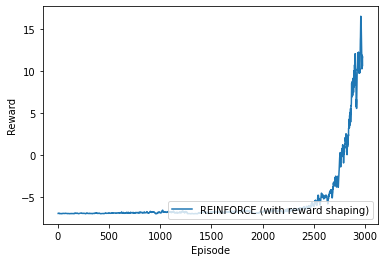

Number of games won: 42
Number of points won: 826
Game score: 7-5 over 24817 frames
Won a game at episode 2980!
Game score: 7-6 over 42440 frames
Won a game at episode 2981!
Game score: 2-7 over 15608 frames
Game score: 7-1 over 15569 frames
Won a game at episode 2983!
Game score: 7-6 over 29120 frames
Won a game at episode 2984!
Game score: 7-2 over 22043 frames
Won a game at episode 2985!
Game score: 6-7 over 29119 frames


In [ ]:
results = Results()
policy_learning_rate = 1e-3
_, basic_reinforce_policy = run_experiment("REINFORCE (with reward shaping)", game_env, num_episodes, reward_shaping=True,
                                           policy_learning_rate=policy_learning_rate, stopping_criterion=30, verbose=True)

In [0]:
results = Results()
policy_learning_rate = 1e-3
_, basic_reinforce_policy = run_experiment("REINFORCE", game_env, num_episodes, reward_shaping=False,
                                           policy_learning_rate=policy_learning_rate, stopping_criterion=30)
_, baseline_reinforce_policy = run_experiment("REINFORCE (with baseline)", game_env, num_episodes, reward_shaping=False,
                                              policy_learning_rate=policy_learning_rate, stopping_criterion=30,
                                              baseline='simple')

In [0]:
# You can save intermediate results to avoid rerunning experiments
results.save('results_exercise_1')

# You can also save your learned networks (you will have to adapt this to your naming of the network modules)
basic_reinforce_policy.policy_net.save('exercise_1_basic_reinforce_policy_net.h5')
baseline_reinforce_policy.policy_net.save('exercise_1_baseline_reinforce_policy_net.h5')

In [0]:
episode = run_fixed_episode_learned(game_env, baseline_reinforce_policy)
render(episode)

**Question 1**: Why is it better to sample an action from the bernoulli distribution rather than just pick the action with highest probability? 

**Answer**: 

**Question 2**: In the train method above we throw away the data from an episode after we use it to train the network (make sure that you do that). Why is it not a good idea to keep the old episodes in our data and train the policy network on both old and new data? (Note: Reusing data can still be possible but requires modifications to the REINFORCE algorithm we are using).

**Answer**:

**Question 3**: In the reward_design function above, we give the agent a positive reward of 0.001 for every frame that the ball is moving in the favorable direction. One may think that such a manipulation will change the optimal policy in a way that the agent tries to maximize the length of each episode instead of necessarily winning the most points. Why is this not case? Can you give a general criteria for the maximum amount of this positive reward such that the optimal policy does not change?

**Answer**:

**Question 4**: Suppose a third action was available (eg. the `DO NOTHING` action that is actually available in this environment but we have excluded for this miniproject). What modifications would you need to make to your implementation to handle this possibility?

**Answer**:

## Exercise 2: Adaptive baseline

Add a second neural network to your model that learns an observation-dependent adaptive baseline and subtracts it from your discounted returns.

1. Modify the `_build_network` function of RLAgent to create a second "value network" when `adaptive` is passed for the baseline argument. The value network should have the same or similar structure as the policy network, without the sigmoid at the output.
3. In addition to training your policy network, train the value network on the Mean-Squared Error compared to the adjusted returns.
4. Train your policy network on R - b(s), i.e. the returns minus the adaptive baseline (the output of the value network). Your implementation should allow for a different learning rate for the value and policy network.
5. Try a few learning rates and plot all your best results together (without baseline, with simple baseline, with adaptive baseline). You may or may not be able to improve on the simple baseline! Return the trained model to use it in the next exercise.

TECHNICAL NOTE: Some textbooks may refer to this approach as "Actor-Critic", where the policy network is the "Actor" and the value network is the "Critic". Sutton and Barto (2018) suggest that Actor-Critic only applies when the discounted returns are bootstrapped from the value network output, as you saw in class. This can introduce instability in learning that needs to be addressed with more advanced techniques, so we won't use it for this miniproject. You can read more about state-of-the-art Actor-Critic approaches here: https://arxiv.org/pdf/1602.01783.pdf

**Mark breakdown: 3 points total**
- 3 points for implementing and plotting the adaptive baseline with the other two conditions, with reasonable performance (i.e. at least similar to the performance in Exercise 1).

In [0]:
policy_learning_rate = 1e-3
value_learning_rate = 1e-3

_, adaptive_policy = run_experiment("REINFORCE (adaptive baseline)", game_env, num_episodes, reward_shaping=False,
                                    policy_learning_rate=policy_learning_rate, 
                                    value_learning_rate=value_learning_rate, stopping_criterion=30,
                                    baseline='adaptive', verbose=True)

In [0]:
results.save('results_exercise_2')
adaptive_policy.policy_net.save('exercise_2_policy_net.h5')
adaptive_policy.value_net.save('exercise_2_value_net.h5')

In [0]:
episode = run_fixed_episode_learned(game_env, adaptive_policy)
render(episode)

## Exercise 3: Value Function Visualization

Ideally, our value network should have learned to predict the relative values across the input space. We can test this by plotting the value prediction for different observations.

1. Write a function to plot the value network prediction across [x,y] space (all possible ball positions) for given (constant) values of the other state variables. All the position state variables always lie in [0,1], with the agent on the left side of the screen (i.e, at X=0 with Y=0.5 being its middle position). (`plt.imshow`, `plt.title` and `plt.colorbar` can be useful)
2. Plot (with titles specifying the state variable combinations) the values for 5-6 combinations of the other 5 state variables. The ball and player velocities are generally within [-1,1] but could lie outside this range. Use the same color bar limits across the graphs so that they can be compared easily. 
3. Answer the question in the markdown cell below in max. 2-3 sentence(s) each.

**Mark breakdown: 3 points total**
- 2 points for the plots of the value function.
- 1 point for answering the question below.

In [0]:
# TODO

**Question 1**: Does your value map make sense for cases where the paddle is moving towards where the ball is going to be? How about when it is moving away from the ball's expected position? Why or why not?

**Answer**:

**Question 2**: It is likely that your value network learns a reasonable value map for some regimes of the state-space while for other combinations of state values, the value map makes little intuitive sense. What could be the reason why some regions are better learned by your network?

**Answer**: